# 2. Classifying Claims - Preparing the Data

In the previous post we looked at the problem for our current project: how to assign an IPC/CPC Section to a first claim of a patent application.

In this post we will look at the steps required to prepare some data for our machine learning algorithms. These steps roughly follow the guide [here](https://machinelearningmastery.com/how-to-prepare-data-for-machine-learning/):

- Step 1: Select Data
- Step 2: Preprocess Data
- Step 3: Transform Data

These steps can take up a fair proportion of the project time. The idea is to obtain a manageable data set and place it in a form where we can apply common machine learning libraries.

---
## 1. Select Data

For our project we want a manageable in-memory dataset. A quick back-of-the-envelope calculation provides the following insight: claims contain around 200 words (we will check this assumption a bit later); each word contains around 5 characters; each character is typically (e.g. using UTF-8 encoding) encoded as 1 Byte (8 bits); we thus have 200 * 5 * 1B = 1kB per claim. 10,000 claims thus make 10MB, which we can easily hold in a 4GB memory.

There are over 9 million US patent publications, which can be downloaded from the [USPTO Bulk Data Archives] (https://www.uspto.gov/learning-and-resources/bulk-data-products). The data is supplied in the form of compressed file archives, where the actual patent data is supplied within these archives as an XML file.

Luckily, we have access to a Python library that provides a wrapper around the USPTO patent publication data as obtained from the bulk data download page. This library can be found on GitHub here (https://github.com/benhoyle/patentdata). This code allows us to parse the compressed files and extract claim text and classification data from the raw XML files.

If you don't want to use or install the patentdata library, you can find a pickle of the extracted data in the accompanying GitHub repository.

One future extension of this project would be to try the classification training on a set of 100,000 or more data samples.

### Code to Get the Data

The code below gets 12,000 random patent publications from data for years 2001 to 2017 across all classifications.  
Once we have the patent publications, we need to extract the text for claim 1 and the classifications. This can be performed using the PatentDoc.Claimset object "get_claim(1)" method and using the "as_string()" method for each classification object in the PatentDoc.Classifications list.

In [1]:
# Start with getting 12,000 patent publications at random
from patentdata.corpus import USPublications
from patentdata.models.patentcorpus import LazyPatentCorpus
import os, pickle

from collections import Counter

# Get the claim 1 and classificationt text

PIK = "claim_and_class.data"

if os.path.isfile(PIK):
    with open(PIK, "rb") as f:
        print("Loading data")
        data = pickle.load(f)
        print("{0} claims and classifications loaded".format(len(data)))
else:
    # Load our list of records
    PIK = "12000records.data"

    if os.path.isfile(PIK):
        with open(PIK, "rb") as f:
            print("Loading data")
            records = pickle.load(f)
            print("{0} records loaded".format(len(records)))
    else:
        path = '/media/SAMSUNG1/Patent_Downloads'
        ds = USPublications(path)
        records = ds.get_records([], "name", sample_size=12000)
        with open(PIK, "wb") as f:
            pickle.dump(records, f)
            print("{0} records saved".format(len(records)))
    
    lzy = LazyPatentCorpus()
    lzy.init_by_filenames(ds, records)
    
    data = list()
    for i, pd in enumerate(lzy.documents):
        try:
            classifications = [c.as_string() for c in pd.classifications]
        except:
            classifications = ""
        try:
            claim1_text = pd.claimset.get_claim(1).text
        except:
            claim1_text = ""
        current_data = (claim1_text, classifications)
        data.append(current_data)
        if (i % 500) == 0:
            print("Saving a checkpoint at {0} files".format(i))
            print("Current data = ", current_data)
            with open(PIK, "wb") as f:
                pickle.dump(data, f)
            
    with open(PIK, "wb") as f:
        pickle.dump(data, f)
        
    print("{0} claims saved".format(len(data)))

Loading data
12000 claims and classifications loaded


## 2. Pre-Processing Data

The code above generates a list of data samples of the form (claim1_text, classifications), where claim1_text is a string representing the text of claim 1 and classifications is a list of strings.

From an inspection of the data, there is some preprocessing to be performed:
- we need to filter out "cancelled" claims - these have the text '(canceled)' rather than any claim text;
- we need to convert the list of string classifications to just a Section letter; and
- sometimes we have strange or non-standard character encodings that can screw up our text processing, the character encodings can thus be cleaned and any non-standard characters replaced.

### Removing Cancelled Claimes

The following codes removes claims that are cancelled (these just have "(canceled)" as text).

In [2]:
# Check for and remove 'cancelled' claims
no_cancelled = [d for d in data if '(canceled)' not in d[0]]

print("There are now {0} claims after filtering out cancelled claims".format(len(no_cancelled)))

There are now 11239 claims after filtering out cancelled claims


### Extract Section Letter

Then we filter the data to extract the first level classification. For simplicity we take the first classification (if there are several classifications) where the data exists. An example data entry is set out below.

In [3]:
# Get classification in the form of A-H
cleaner_data = list()
for d in no_cancelled:
    if len(d[1]) >= 1:
        if len(d[1][0]) > 3:
            classification = d[1][0][2]
            cleaner_data.append(
                (d[0], classification)
            )

print("There are now {0} claims after extracting classifications".format(len(cleaner_data)))

There are now 11238 claims after extracting classifications


### Cleaning Characters

To help further processing we will clean the characters of the text. The patentdata library has a function that replaces certain characters (e.g. different versions of '"' or '-') with a reduced set of common printable characters.

In [4]:
# Clean the characters in the data to use a reduced set of printable characters
# There is a function in patentdata to do this
from patentdata.models.lib.utils import clean_characters

cleaner_data = [(clean_characters(d[0]), d[1]) for d in cleaner_data]

### Example

Here is an example of one data sample following processing:

In [5]:
cleaner_data[55]

('\n1. A sensing assembly for sensing a level of liquid in a reservoir, said sensing assembly comprising: \na first input port for receiving a first input voltage signal; \na second input port for receiving a second input voltage signal; \nan excitation circuit electrically connected to said first and second input ports for receiving the first and second input voltage signals and for generating a first excitation signal and a second excitation signal, said excitation circuit includes first and second excitation electrodes extending along a portion of the reservoir, said first and second excitation electrodes disposed adjacent to and separated by said first receiving electrode; and \na receiving circuit disposed adjacent said excitation circuit defining a variable capacitance with said excitation circuit, wherein said receiving circuit includes first and second receiving electrodes extending along a portion of the reservoir and a first trace connected to ground and extending between sai

### Saving the Data - Interim

Let's quickly save our claims and classifications as a Pickle file called "raw_data". This saves us having to do the steps set out above again if something goes wrong.

In [6]:
raw_data = cleaner_data
with open("raw_data.pkl", "wb") as f:
    pickle.dump(raw_data, f)

## Interlude - Exploring the Data

Here we will take a little interlude to explore our data and get a feel for its structure.

In [7]:
from nltk import word_tokenize

data_in_words = [(word_tokenize(d[0]), d[1]) for d in raw_data]

In [8]:
# Here is an example
data_in_words[55][0][0:10]

['1', '.', 'A', 'sensing', 'assembly', 'for', 'sensing', 'a', 'level', 'of']

#### Claim Length

Let's start with looking at the longest claim.

In [9]:
# What is our maximum claim length?
print("Max claim length = {0}".format(max([len(d[0]) for d in data_in_words])))

Max claim length = 6134


That's long! 6134 words.   

Let's have a look at how the length (in words) of our claims is distributed.

In [10]:
claim_length_counter = Counter([len(d[0]) for d in data_in_words])

We can quickly have a look at a histogram of the lengths.

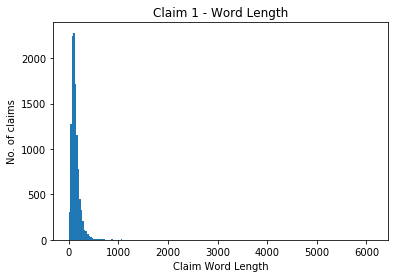

In [11]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

bins = np.linspace(0, max(claim_length_counter.elements()), 200)
plt.hist(list(claim_length_counter.elements()), bins)
plt.title('Claim 1 - Word Length')
plt.ylabel('No. of claims')
plt.xlabel('Claim Word Length')

As we can see the 6134 length claim is a clear outlier. The distribution is focused around 0 to around 600 words. Let's zoom in on that.

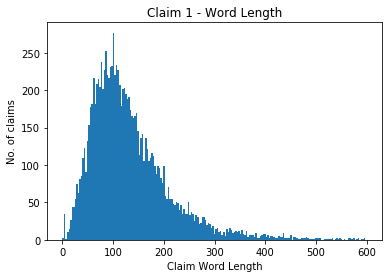

In [12]:
bins = np.linspace(0, 600, 200)
plt.hist(list(claim_length_counter.elements()), bins)
plt.title('Claim 1 - Word Length')
plt.ylabel('No. of claims')
plt.xlabel('Claim Word Length')

When applying deep learning algorithms we often need to set a maximum sequence length. When dealing with words, this is equal to the maximum number of words expected in a claim. A lower maximum sequence length will help reduce our training time. 

If we take all claims of less than 250 words this would still include most of the data.  

#### Words

Now let's have a look at the words themselves.

In [14]:
# Look at the words in our claims
word_counter = Counter(sum([d[0] for d in data_in_words], list()))
print("There are {0} different tokens in our dataset.\n".format(len(word_counter)))
print("The 100 most common words are:", word_counter.most_common(50))

There are 34075 different tokens in our dataset.

The 100 most common words are: [('the', 103372), ('a', 83989), (',', 66878), ('of', 55405), ('and', 44003), ('to', 37112), (';', 30142), ('.', 22809), ('said', 22647), (')', 20018), ('in', 18044), ('(', 17946), ('an', 17519), ('first', 16033), ('for', 15347), ('is', 14532), ('1', 12720), ('comprising', 12718), ('at', 12212), ('second', 12028), (':', 11834), ('one', 11096), ('or', 10910), ('from', 10621), ('with', 10478), ('A', 9265), ('least', 8529), ('by', 8240), ('wherein', 8237), ('on', 8031), ('that', 7425), ('having', 6846), ('device', 6228), ('which', 6177), ('data', 5856), ('plurality', 5494), ('each', 5283), ('portion', 4687), ('method', 4675), ('surface', 4492), ('signal', 4193), ('being', 3993), ('unit', 3977), ('system', 3739), ('between', 3621), ('end', 3548), ('layer', 3547), ('are', 3497), ('member', 3353), ('image', 3209)]


#### Section Labels

Let us now have a look at our Section classes. 

In [15]:
class_count = Counter([d[1] for d in cleaner_data])
class_count

Counter({'A': 1777,
         'B': 1449,
         'C': 865,
         'D': 54,
         'E': 269,
         'F': 735,
         'G': 3335,
         'H': 2754})

What is quite interesting is we see that the data is mainly clusted around class A, B, G and H. Classes C, D, E and F have a limited number of associated claims.  

***A future extension to this project may be to balance the data samples. This may improve performance.***

# 3. Transform the Data

Machine learning algorithms generally work with numbers (typically floats of 32 or 64 bits). These numbers are arranged in multi-dimensional arrays called tensors.

Most machine learning algorithms expect a training set of data to be formatted into an 'X' tensor. One dimension of this tensor represents the different training samples. Another set of dimenions then represent the data of each training sample. For example, if each claim was represented as a one-dimensional vector [3, 1, 2, ..., 3] then X might comprise a matrix where rows of the matrix represent different samples and the columns of the matrix represent different features of the sample.

For supervised classification tasks each sample has an associated label. These are typically expected in a 'Y' tensor. Again, one dimension of this tensor represents the different training samples, while another set of dimensions represents the actual classification value for a particular sample. For example, in a simple binary case, Y may comprise a vector of 0 or 1 values.

In many supervised learning cases, we are thus looking to map an array (a row of our X tensor) to a scalar representing a group label.

## Working with Text

When classifying images or measurement data, we generally already have numeric input data. However, text is different - we generally have a long string of characters as input. We thus need to convert our text data into a numeric vector. Moreover, we generally need a fixed-length input vector, whereas our text data can vary in length. 

In this project we will look at two ways this can be done:
- counting words; and
- using recurrent neural networks.

As differences in converting the text may lead to differences in performance, their implementation may be revisited when trying to improve our results. Initially we will use a standardised set of function, then look to tweak these later.

### Counting Words

A common techique to converting text to a numeric vector is by creating an array of length *l* that stores count values for the *l* most common words across the corpus of data. These are sometimes referred to as "bag-of-words" models, as they treat the text as a collection of words without considering word order.

There are [two widely-used flavours](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) of word counts:
- term frequency (TF) vectors: these count the occurrences of each word; and
- term frequency - document inverse frequency vectors: these weight the term counts to decrease the relevance of words that commonly occur across the corpus.

There are functions in gensim, scikit-learn and keras that generate numeric vectors from text data based on these metrics. We will apply some below.

### Using Recurrent Neural Networks

Counts of words do not take word order into account. Recurrent neural networks are a form of neural network designed to process sequences of data values. In our case, we can convert each word in a claim into an integer index in a dictionary, and then use the resulting list of integers as input for a recurrent neural network.

In this post we will look at how to shape numeric X and Y vectors based on our "claim and classification" data (the "raw_data" above). In other posts we may use built in functions of machine learning libraries to do this for us.

---

## Creating Y Vector

Creating numeric Section label data is relatively straightforward and doesn't leave much room for tinkering. We will apply this first.

We can encode our numeric data in several ways, and different machine learning algorithms prefer different formats. Two popular formats are:
- a single integer value representing the class (e.g. A = 0, B = 1 etc); and
- a one-hot encoding where a 1 in an array indicates the class (e.g. [1, 0, ...0] = A, [0, 1, ...0] = B).

We will create and save both.

In [17]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Y_class = [d[1] for d in raw_data]

# encode class values as integers
label_e = LabelEncoder()
label_e.fit(Y_class)
encoded_Y = label_e.transform(Y_class)
# convert integers to dummy variables (i.e. one hot encoded)
Y = to_categorical(encoded_Y)
print("Our classes are now a matrix of {0}".format(Y.shape))
print("Original label: {0}; Converted label: {1}".format(Y_class[0], Y[0]))

Our classes are now a matrix of (11238, 8)
Original label: A; Converted label: [ 1.  0.  0.  0.  0.  0.  0.  0.]


## Creating X Vector - TD-IDF

Initially, we will use a TD-IDF count to convert our text into a fixed-length vector. We can then see later whether recurrent neural networks improve our classification accuracy.  

Luckily keras provides a [handy utility](https://keras.io/preprocessing/text/#tokenizer) to tokenise our text data and output a fixed-length TD-IDF count based on the top *l* words. We saw above that our claims had ~35,000 unique tokens. We'll initially try with a vector limited to 5000 entries. The length of our vector is another hyperparameter we can play with later. The keras tokeniser also converts the text to lowercase and filters out punctuation (see the link above to change the default parameters).

In [18]:
from keras.preprocessing.text import Tokenizer

docs = [d[0] for d in raw_data]

# create the tokenizer
t = Tokenizer(num_words=5000)
# fit the tokenizer on the documents
t.fit_on_texts(docs)

X = t.texts_to_matrix(docs, mode='tfidf')

In [19]:
print("Our data has the following dimensionality: ", X.shape)
print("An example array is: ", X[0][0:100])

Our data has the following dimensionality:  (11238, 5000)
An example array is:  [ 0.          0.          2.43021996  2.08331543  1.71570602  2.52741068
  4.87087867  2.99092954  2.24937914  0.          2.06184914  2.64736857
  0.6933252   1.79712096  1.15982119  0.          1.47794342  1.26289711
  0.          1.16317528  0.          1.29314655  0.          0.
  1.38569402  1.36640725  0.          3.80265818  0.          0.
  2.92091401  0.          0.          0.          8.0221356   5.73719819
  0.          0.          0.          0.          0.          1.89505548
  0.          0.          0.          3.76681667  1.94774291  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          2.32203465
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          2.45289367  0.          0.          0.
  0.          0.          4.79789823  0.    

## Save Our Data

Now we can save our X and Y data to load for testing a set of machine learning algorithms.

In [20]:
with open("encoded_data.pkl", "wb") as f:
    pickle.dump((X, Y), f)